# CaLNG Supply Chain Optimization
This project focuses on optimizing the liquefied natural gas (LNG) procurement strategy for a utility company facing uncertain winter demand. By leveraging Monte Carlo Simulation and Grid Search Optimization, the goal is to identify the optimal balance between a fixed Take-or-Pay contract with CaLNG and the volatile Pipeline Spot Market.

### Objectives
- Cost Minimization: Find the optimal pair of total_LNG capacity and peak_intake_from_pipeline that minimizes the expected seasonal cost.
- Risk Analysis: Evaluate seasonal cost volatility through 5,000 simulated demand scenarios.
- Strategic Insight: Provide qualitative arguments on contract feasibility and supply chain structuring based on simulation results.

### Key Findings
- Optimal Total LNG: 900.0 MMcf
- Optimal Peak Pipeline Intake: 180.0 MMcf
- Minimum Expected Cost: ~$25.13M

## Setup

In [1]:
# load libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)

In [2]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [3]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [4]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


## Set Parameters

In [5]:
# Initial parameters
calng_price = 7.50 # set by CaLNG
mean_daily_demand = 144
std_dev_daily_demand = 59
num_draws = 5000 # Number of Monte Carlo simulations per scenario

# Define search ranges for optimization
total_lng_range = list(range(700, 1301, 50))
peak_intake_range = list(range(170, 201, 5))

# Pre-generate random demand matrix to optimize performance
num_days = len(demand_data)
np.random.seed(42) # Fixed seed for reproducibility
all_sim_demands = np.random.normal(mean_daily_demand, std_dev_daily_demand, (num_draws, num_days))
all_sim_demands = np.maximum(all_sim_demands, 0) # Ensure demand is never negative

# Nested Optimization Loop

In [6]:
results = []
print("Running optimization simulations...")

for t_lng in total_lng_range:
    for p_intake in peak_intake_range:
        sim_costs = []
        
        for i in range(num_draws):
            daily_demands = all_sim_demands[i]
            
            # Calculate demand for LNG
            lng_needed = np.maximum(daily_demands - p_intake, 0)
            
            # Ensure LNG consumption does not exceed total_lng
            actual_lng_usage = np.zeros(num_days)
            remaining_lng = t_lng
            for d in range(num_days):
                use = min(lng_needed[d], remaining_lng)
                actual_lng_usage[d] = use
                remaining_lng -= use
            
            # Calculate pipeline intake and the resulting spot price
            pipeline_intake = daily_demands - actual_lng_usage
            # Price formula provided in the case: exp(max(0, (intake - 144)/60))
            pipeline_prices = np.exp(np.maximum(0, (pipeline_intake - 144) / 60))
            
            # Total Cost = (Pipeline Costs + Fixed CaLNG Contract Cost) * 1000
            total_cost = (np.sum(pipeline_intake * pipeline_prices) + (t_lng * calng_price)) * 1000
            sim_costs.append(total_cost)
            
        # Store the average and standard deviation of costs for this specific parameter pair
        results.append({
            'total_lng': t_lng,
            'peak_intake': p_intake,
            'avg_cost': np.mean(sim_costs),
            'std_cost': np.std(sim_costs)
        })

        current_res = results[-1]
        print(f"Testing: LNG={t_lng}, Peak={p_intake} -> Avg Cost: ${current_res['avg_cost']:,.0f}")

# Convert results list to DataFrame for analysis
df_res = pd.DataFrame(results)

Running optimization simulations...
Testing: LNG=700, Peak=170 -> Avg Cost: $26,987,730
Testing: LNG=700, Peak=175 -> Avg Cost: $26,298,216
Testing: LNG=700, Peak=180 -> Avg Cost: $25,686,851
Testing: LNG=700, Peak=185 -> Avg Cost: $25,293,228
Testing: LNG=700, Peak=190 -> Avg Cost: $25,236,231
Testing: LNG=700, Peak=195 -> Avg Cost: $25,534,101
Testing: LNG=700, Peak=200 -> Avg Cost: $26,101,931
Testing: LNG=750, Peak=170 -> Avg Cost: $26,680,461
Testing: LNG=750, Peak=175 -> Avg Cost: $25,992,130
Testing: LNG=750, Peak=180 -> Avg Cost: $25,439,026
Testing: LNG=750, Peak=185 -> Avg Cost: $25,179,027
Testing: LNG=750, Peak=190 -> Avg Cost: $25,281,688
Testing: LNG=750, Peak=195 -> Avg Cost: $25,725,895
Testing: LNG=750, Peak=200 -> Avg Cost: $26,391,837
Testing: LNG=800, Peak=170 -> Avg Cost: $26,397,061
Testing: LNG=800, Peak=175 -> Avg Cost: $25,716,415
Testing: LNG=800, Peak=180 -> Avg Cost: $25,258,534
Testing: LNG=800, Peak=185 -> Avg Cost: $25,144,700
Testing: LNG=800, Peak=190 -

In [7]:
# Identify the Optimal Solution
optimal_row = df_res.loc[df_res['avg_cost'].idxmin()]
best_lng = optimal_row['total_lng']
best_peak = optimal_row['peak_intake']

print(f"Optimal Total LNG: {best_lng}")
print(f"Optimal Peak Intake: {best_peak}")
print(f"Minimum Expected Cost: ${optimal_row['avg_cost']:,.2f}")

Optimal Total LNG: 900.0
Optimal Peak Intake: 180.0
Minimum Expected Cost: $25,126,966.91


# Visualization

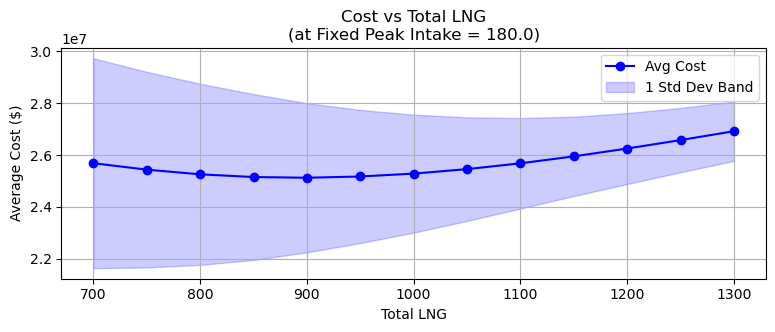

In [8]:
# Cost vs Total LNG (holding Peak Intake at its optimum)
plt.subplot(1, 2, 1)
data_i = df_res[df_res['peak_intake'] == best_peak]
plt.plot(data_i['total_lng'], data_i['avg_cost'], 'b-o', label='Avg Cost')
plt.fill_between(data_i['total_lng'], 
                 data_i['avg_cost'] - data_i['std_cost'], 
                 data_i['avg_cost'] + data_i['std_cost'], color='blue', alpha=0.2, label='1 Std Dev Band')
plt.title(f'Cost vs Total LNG\n(at Fixed Peak Intake = {best_peak})')
plt.xlabel('Total LNG')
plt.ylabel('Average Cost ($)')
plt.legend()
plt.grid(True)

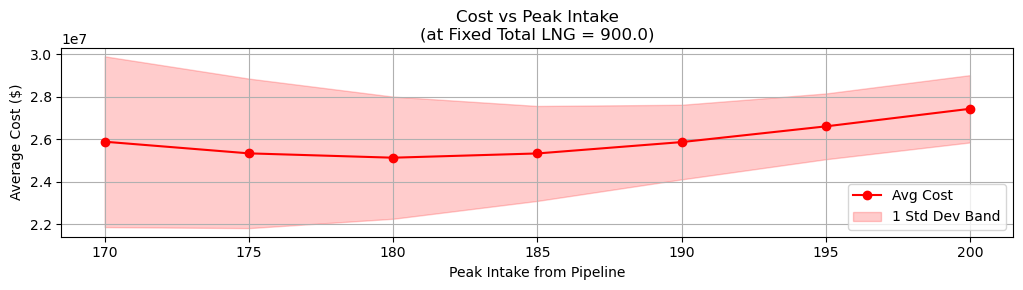

In [9]:
# Cost vs Peak Intake (holding Total LNG at its optimum)
plt.subplot(1, 2, 2)
data_ii = df_res[df_res['total_lng'] == best_lng]
plt.plot(data_ii['peak_intake'], data_ii['avg_cost'], 'r-o', label='Avg Cost')
plt.fill_between(data_ii['peak_intake'], 
                 data_ii['avg_cost'] - data_ii['std_cost'], 
                 data_ii['avg_cost'] + data_ii['std_cost'], color='red', alpha=0.2, label='1 Std Dev Band')
plt.title(f'Cost vs Peak Intake\n(at Fixed Total LNG = {best_lng})')
plt.xlabel('Peak Intake from Pipeline')
plt.ylabel('Average Cost ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()